# Description

In this notebook, I will code about quantization. 
- The main object is torch tensor.

In [19]:
import os 
from typing import List, Dict, Optional, Union, Callable
import matplotlib.pyplot as plt

import torch

# 1. Quantization

In [ ]:
def compute_quantization_param(x: torch.Tensor, num_bits=8) -> Union[float, int]:
    """
    Compute the scale and zero-point for quantization.
    """
    min_val, max_val = x.min(), x.max()

    qmin = -(2 ** (num_bits - 1))
    qmax = 2 ** (num_bits - 1) - 1

    scale = (max_val - min_val) / (qmax - qmin)

    initial_zero_point = qmin - min_val / scale
    if initial_zero_point < qmin:
        zero_point = qmin
    elif initial_zero_point > qmax:
        zero_point = qmax
    else:
        zero_point = initial_zero_point
    zero_point = int(zero_point)

    return scale, zero_point

def quantize_tensor(x: torch.Tensor, scale: float, zero_point: int, num_bits=8):
    qmin = -(2 ** (num_bits - 1))
    qmax = 2 ** (num_bits - 1) - 1

    q_x = zero_point + x / scale
    q_x.clamp_(qmin, qmax).round_()
    return q_x.to(torch.int8)

def dequantize_tensor(q_x: torch.Tensor, scale: float, zero_point: int):
    return scale * (q_x.float() - zero_point)

In [32]:
N = 1024
input_type = torch.float16

x = torch.randn(N, N, dtype=input_type)
print(f"Shape of x: {x.shape} - Dtype: {x.dtype}")
print(f"Min: {x.min().item()}, Max: {x.max().item()}")

Shape of x: torch.Size([1024, 1024]) - Dtype: torch.float16
Min: -3.904296875, Max: 3.904296875


In [42]:
quantized_bit = 4

scale, zero_point = compute_quantization_param(x, num_bits=quantized_bit)
print(f"Scale: {scale}, Zero point: {zero_point}")
print()

x_quantized = quantize_tensor(x, scale, zero_point, num_bits=quantized_bit)
print(f"Shape of quantized x: {x_quantized.shape}")
print(f"Dtype: {x_quantized.dtype}")
print(f"Min: {x_quantized.min().item()}, Max: {x_quantized.max().item()}")

Scale: 0.5205078125, Zero point: 0

Shape of quantized x: torch.Size([1024, 1024])
Dtype: torch.int8
Min: -8, Max: 7


In [40]:
x_dequantized = dequantize_tensor(x_quantized, scale, zero_point)
print(f"Shape of dequantized x: {x_dequantized.shape}")

error = torch.abs(x - x_dequantized).mean()
print(f"Mean absolute error: {error.item()}")

Shape of dequantized x: torch.Size([1024, 1024])
Mean absolute error: 0.13009463250637054


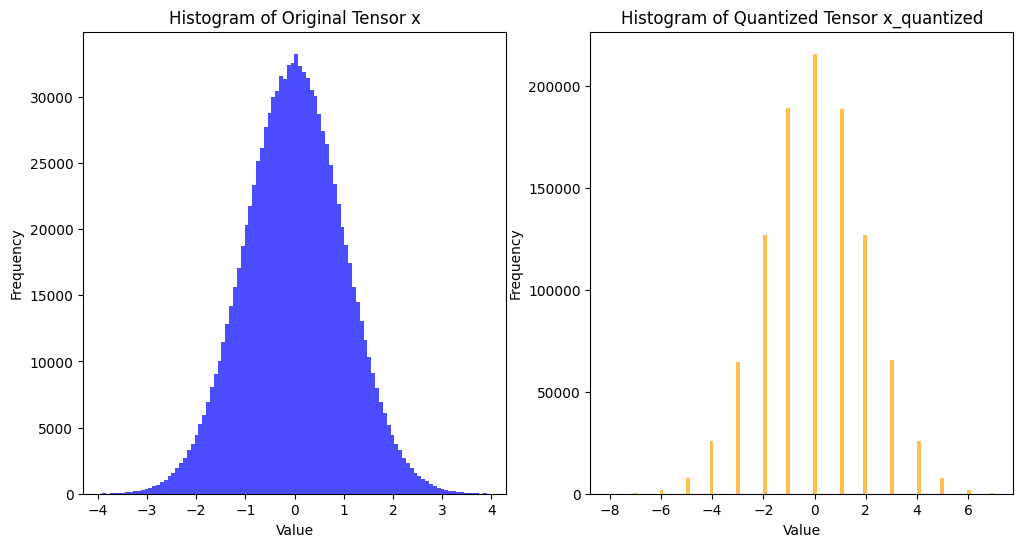

In [41]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(x.view(-1).numpy(), bins=100, alpha=0.7, color='blue')
plt.title('Histogram of Original Tensor x')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(x_quantized.view(-1).numpy(), bins=100, alpha=0.7, color='orange')
plt.title('Histogram of Quantized Tensor x_quantized')
plt.xlabel('Value')
plt.ylabel('Frequency') 
plt.show()